
Processing recording: log_1626_93118.csv


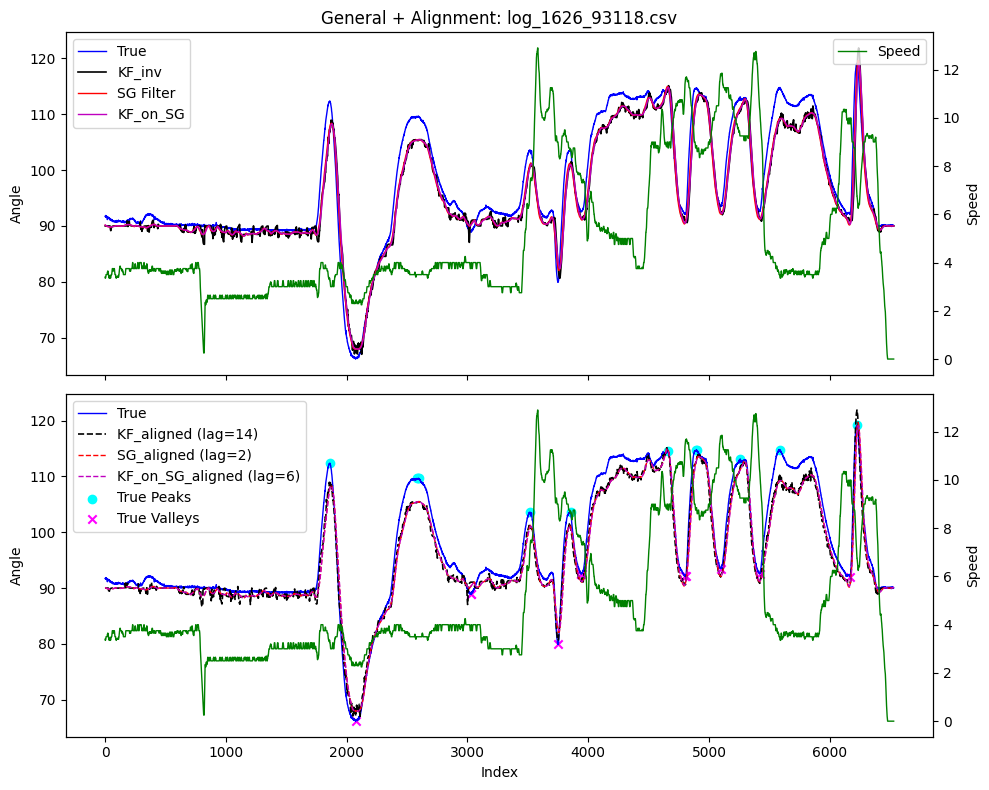

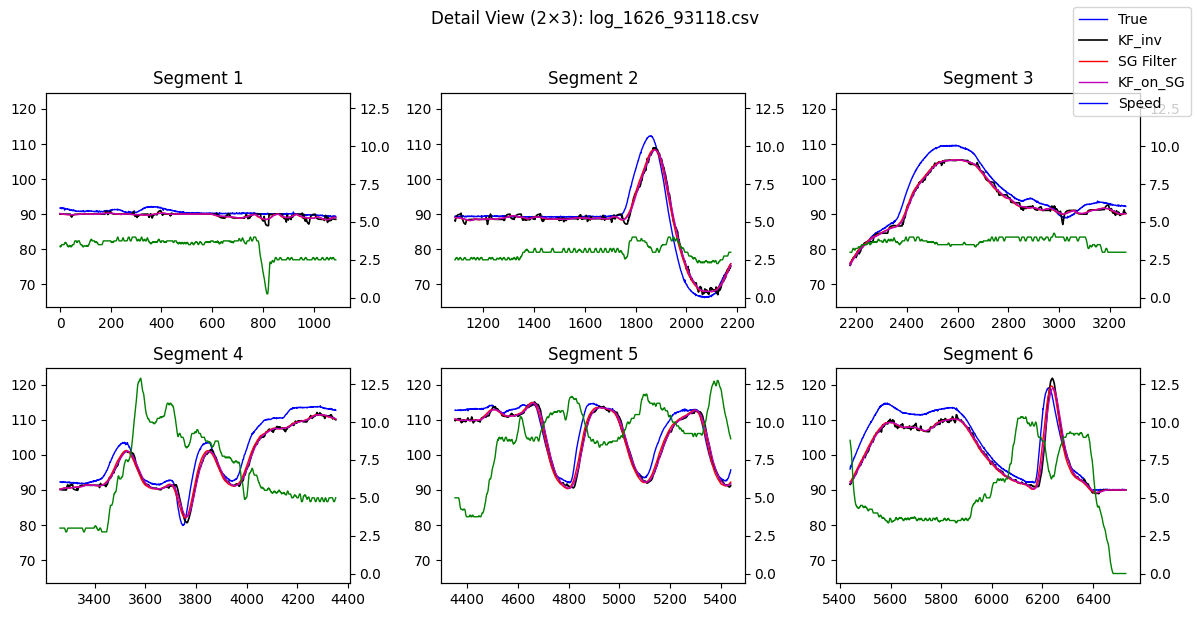


Processing recording: log_1622_64296.csv


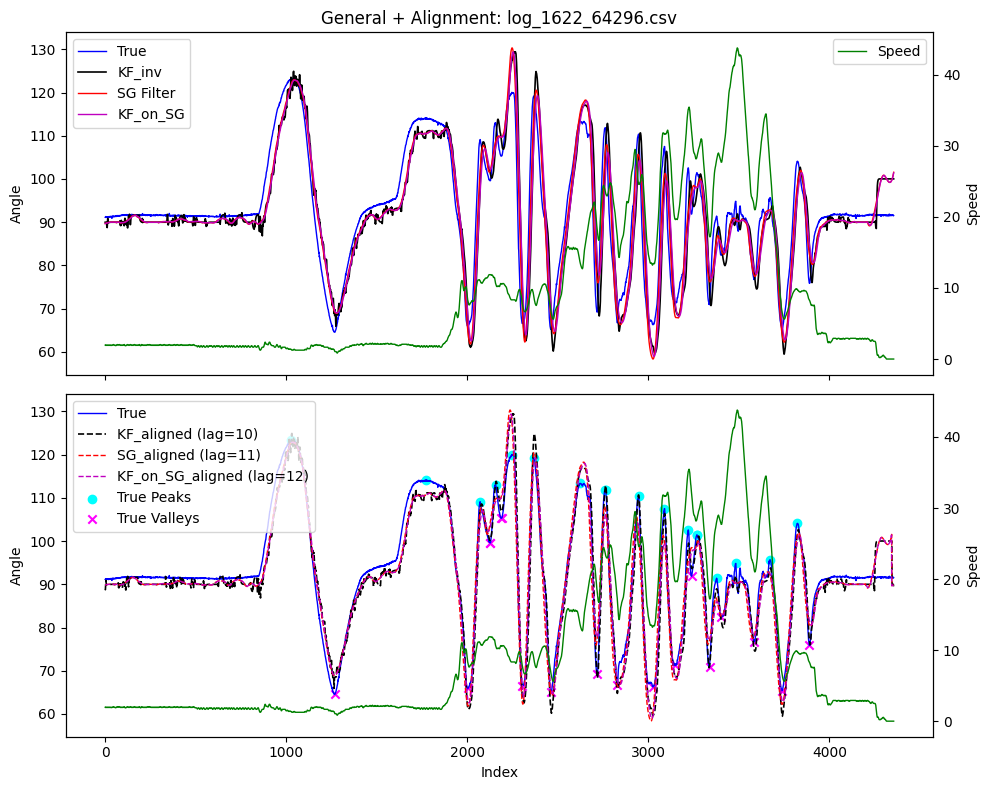

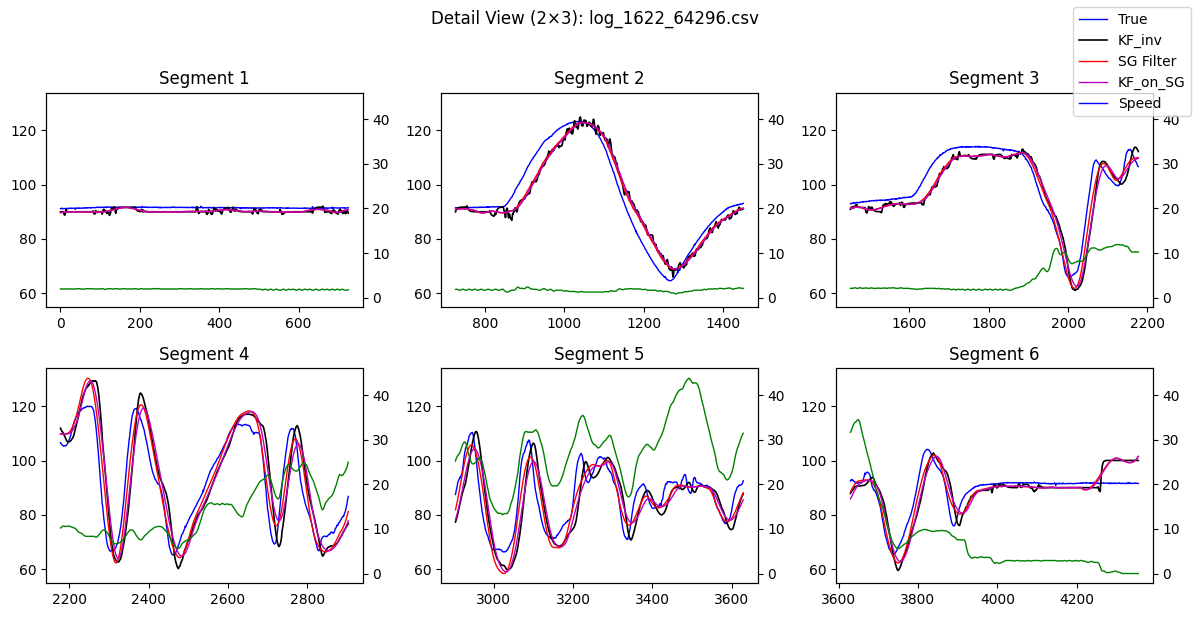


Processing recording: log_1618_76251.csv


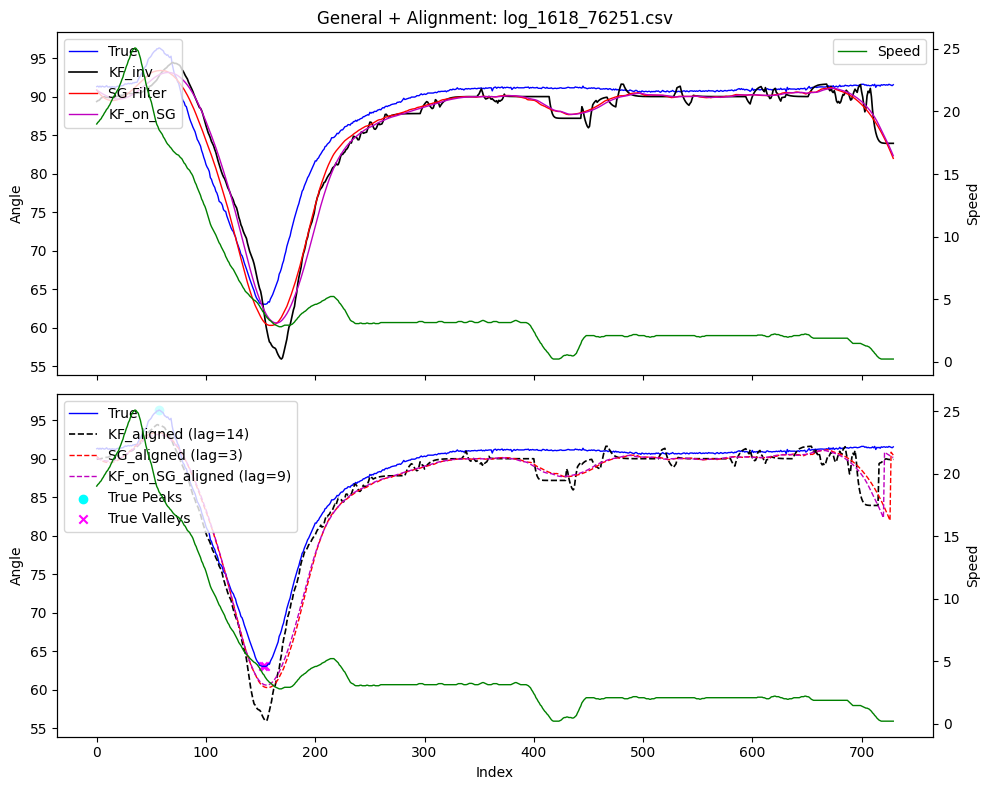

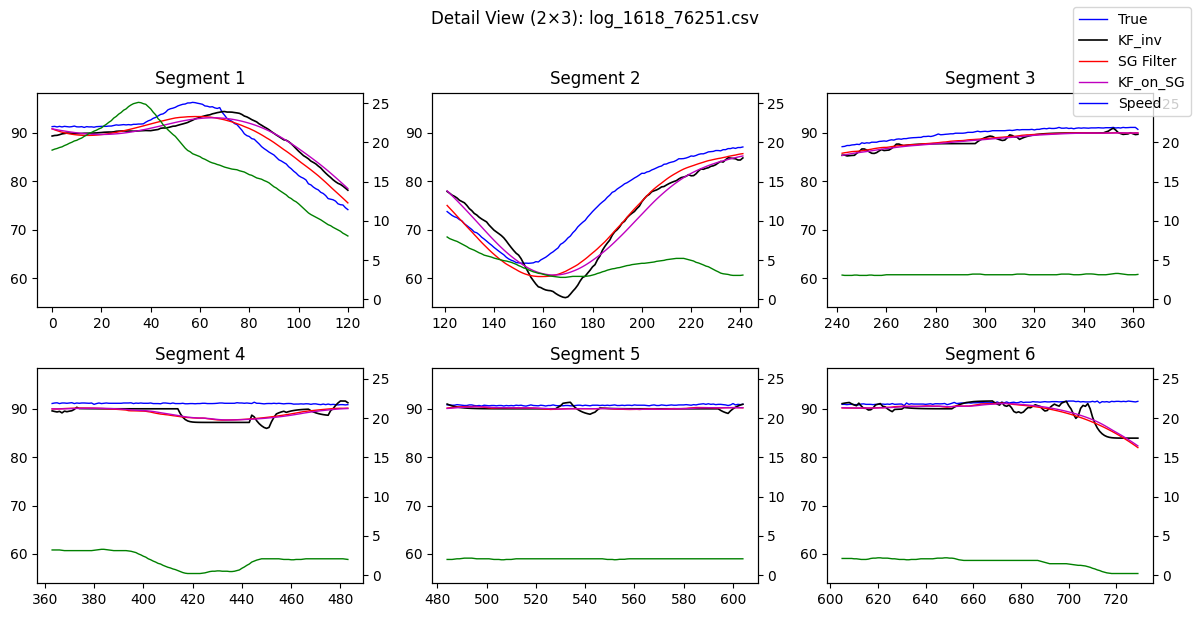


=== Combined Performance Metrics for All Recordings ===
          Filename   Method     RMSE      MAE  Extrema_MAE  MAPE_pk  MAVE_vl  Lag
log_1626_93118.csv   KF_inv 2.215443 1.818463     2.063131 2.842129 1.344055   14
log_1626_93118.csv       SG 2.409414 1.886934     2.142070 2.795280 1.539107    2
log_1626_93118.csv KF_on_SG 2.489492 1.915309     2.217679 2.973309 1.520175    6
log_1622_64296.csv   KF_inv 3.284410 2.602261     2.374795 2.389692 2.359898   10
log_1622_64296.csv       SG 3.392386 2.632085     4.023484 4.101822 3.945145   11
log_1622_64296.csv KF_on_SG 3.254220 2.575631     4.165224 4.702931 3.627518   12
log_1618_76251.csv   KF_inv 2.177889 1.541163     5.180799 2.006123 6.768138   14
log_1618_76251.csv       SG 2.353598 1.733310     2.721105 2.934972 2.614171    3
log_1618_76251.csv KF_on_SG 2.220858 1.679483     2.615813 3.188037 2.329700    9


In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------------------------------------------------------------------
# 1. Load & Preprocess Function
# -----------------------------------------------------------------------------------
def load_and_preprocess(path):
    """
    Loads a semicolon-delimited CSV, computes raw angle from light sensors,
    interpolates zero dropouts in target, preprocesses speed, and applies a Hampel filter on raw.
    Returns a DataFrame with added columns: ['raw','target_clean','speed','cleaned_raw'].
    """
    df = pd.read_csv(path, sep=';')

    # Identify relevant columns by regex
    angle_col = df.filter(regex='Deichsel').columns[0]
    speed_col = df.filter(regex='Geschwindigkeit').columns[0]
    Lse = df.filter(regex='Durchschnitt_L_SE').columns[0]
    Lbe = df.filter(regex='Durchschnitt_L_Be_SE').columns[0]
    Rse = df.filter(regex='Durchschnitt_R_SE').columns[0]
    Rbe = df.filter(regex='Durchschnitt_R_[Bb]e_SE').columns[0]

    # Compute raw hitch-angle proxy:
    # raw = 90 + [ ((L - (L - R)/2) / (L*R)) * (L - (L - R)/2) * (L - R ) ] / (L - (L - R)/2) * 100
    df['L'] = df[Lse] + df[Lbe] + 16
    df['R'] = df[Rse] + df[Rbe] + 16
    df['raw'] = 90 + (((df.L - (df.L - df.R)/2) / (df.L * df.R)) *
                     (df.L - (df.L - df.R)/2) * (df.L - df.R)) / (
                     df.L - (df.L - df.R)/2) * 100

    # Clean target: replace zeros with NaN, then interpolate
    df['target_clean'] = df[angle_col].replace(0, np.nan).interpolate(method='linear', limit_direction='both')

    # Speed preprocessing:
    speed = df[speed_col].clip(lower=0)
    non_zero = np.where(speed != 0)[0]
    if len(non_zero) > 0:
        fnz, lnz = non_zero[0], non_zero[-1]
        speed.iloc[fnz:lnz+1] = speed.iloc[fnz:lnz+1].replace(0, np.nan)
    df['speed'] = speed.interpolate().rolling(window=5, center=True, min_periods=1).mean().fillna(0)

    # Hampel filter on 'raw' to remove spikes (causal window=5)
    x = df['raw'].copy()
    k, w = 1.4826, 5
    for i in range(w, len(x)-w):
        window = x[i-w:i+w+1]
        med = np.median(window)
        mad = k * np.median(np.abs(window - med))
        if abs(x[i] - med) > 3 * mad:
            x[i] = med
    df['cleaned_raw'] = x

    return df

# -----------------------------------------------------------------------------------
# 2. Extrema Detection & Alignment Functions
# -----------------------------------------------------------------------------------
def detect_extrema(arr):
    """
    Detects local maxima (peaks) and minima (valleys) in arr using 10% prominence.
    Returns arrays of peak indices and valley indices.
    """
    prom = 0.1 * (np.nanmax(arr) - np.nanmin(arr))
    peaks, _ = find_peaks(arr, prominence=prom)
    valleys, _ = find_peaks(-arr, prominence=prom)
    return peaks, valleys

def align_by_extrema(y, t):
    """
    Aligns series y to reference series t using extrema matching:
    1. Detect true peaks/valleys (tp, tv) in t.
    2. Detect peaks/valleys in y.
    3. Compute shifts between each true extremum and its nearest filtered extremum.
    4. Median of shifts = lag. Roll y by -lag to align.
    Returns rolled y, true peaks, true valleys, and lag.
    """
    tp, tv = detect_extrema(t)
    prom_y = 0.1 * (np.nanmax(y) - np.nanmin(y))
    yp, _ = find_peaks(y, prominence=prom_y)
    yv, _ = find_peaks(-y, prominence=prom_y)
    shifts = []
    for idx in np.concatenate([tp, tv]):
        if len(yp) > 0:
            shifts.append(yp[np.argmin(np.abs(yp - idx))] - idx)
        if len(yv) > 0:
            shifts.append(yv[np.argmin(np.abs(yv - idx))] - idx)
    lag = int(np.median(shifts)) if shifts else 0
    return np.roll(y, -lag), tp, tv, lag

# -----------------------------------------------------------------------------------
# 3. KF_inv (Speed‐Aware Kalman Filter)
# -----------------------------------------------------------------------------------
def kf_inv(x, v):
    """
    One-state Kalman filter using speed v to adapt process noise:
    Q = 1e-2 + 1e-1 * (1 / max(v[i], 0.1)), R = 1.0.
    Returns filtered array y.
    """
    y = np.zeros_like(x)
    P = np.zeros_like(x)
    y[0], P[0] = x[0], 1.0
    for i in range(1, len(x)):
        vs = max(v[i], 0.1)
        Q = 1e-2 + 1e-1 * (1 / vs)
        Pp = P[i-1] + Q
        K = Pp / (Pp + 1.0)
        y[i] = y[i-1] + K * (x[i] - y[i-1])
        P[i] = (1 - K) * Pp
    return y

# -----------------------------------------------------------------------------------
# 4. Main Processing Loop for All Recordings
# -----------------------------------------------------------------------------------
if __name__ == "__main__":
    # Directory containing all CSV recordings
    recordings_dir = "recordings"

    # Optional: Exclude first N seconds based on timestamp (ms); set None to disable
    exclude_first_seconds = 20.0  # in seconds

    # Initialize a list to collect metrics for all files
    all_metrics = []

    # Loop through each CSV file in the recordings directory
    for fname in os.listdir(recordings_dir):
        if not fname.lower().endswith(".csv"):
            continue

        file_path = os.path.join(recordings_dir, fname)
        print(f"\nProcessing recording: {fname}")

        # 4.1 Load and preprocess
        df = load_and_preprocess(file_path)

        # 4.2 Optionally exclude initial period based on timestamp column (ms)
        if exclude_first_seconds is not None:
            t0 = df["ESP Time"].iloc[0]
            cutoff = t0 + int(exclude_first_seconds * 1000)
            df = df[df["ESP Time"] >= cutoff].reset_index(drop=True)

        # 4.3 Extract arrays for processing
        idx = df.index.values
        t_clean = df["target_clean"].values
        speed = df["speed"].values
        raw = df["cleaned_raw"].values

        # 4.4 Apply filters
        kf_out = kf_inv(raw, speed)
        wl = 101 if len(raw) >= 101 else (len(raw)//2)*2 + 1
        sg_out = savgol_filter(raw, wl, 3)
        kf_on_sg_out = kf_inv(sg_out, speed)

        # 4.5 Compute metrics for each filter on this file
        for name, y in [("KF_inv", kf_out), ("SG", sg_out), ("KF_on_SG", kf_on_sg_out)]:
            y_al, tp, tv, lag = align_by_extrema(y, t_clean)
            mask = ~np.isnan(t_clean) & ~np.isnan(y_al)
            rmse = np.sqrt(mean_squared_error(t_clean[mask], y_al[mask]))
            mae = mean_absolute_error(t_clean[mask], y_al[mask])
            mape_pk = np.mean(np.abs(y_al[tp] - t_clean[tp])) if len(tp) > 0 else np.nan
            mave_vl = np.mean(np.abs(y_al[tv] - t_clean[tv])) if len(tv) > 0 else np.nan
            ext_idx = np.concatenate([tp, tv])
            ext_mae = np.mean(np.abs(y_al[ext_idx] - t_clean[ext_idx])) if len(ext_idx) > 0 else np.nan
            all_metrics.append((fname, name, rmse, mae, ext_mae, mape_pk, mave_vl, lag))

        # 4.6 Plot General + Alignment for this file
        kf_al, tp, tv, lag_kf = align_by_extrema(kf_out, t_clean)
        sg_al, _, _, lag_sg = align_by_extrema(sg_out, t_clean)
        kf_on_sg_al, _, _, lag_kf_sg = align_by_extrema(kf_on_sg_out, t_clean)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        # Top subplot: unaligned signals + speed
        ax1.plot(idx, t_clean,    'b-', lw=1,   label='True')
        ax1.plot(idx, kf_out,     'k-', lw=1.2, label='KF_inv')
        ax1.plot(idx, sg_out,     'r-', lw=1,   label='SG Filter')
        ax1.plot(idx, kf_on_sg_out,'m-', lw=1,  label='KF_on_SG')
        ax1.set_ylabel('Angle')
        ax1.set_title(f"General + Alignment: {fname}")
        ax1.legend(loc='upper left')
        ax1_r = ax1.twinx()
        ax1_r.plot(idx, speed, 'g-', lw=1, label='Speed')
        ax1_r.set_ylabel('Speed')
        ax1_r.legend(loc='upper right')

        # Bottom subplot: aligned signals with true extrema markers + speed
        ax2.plot(idx, t_clean,     'b-',  lw=1,   label='True')
        ax2.plot(idx, kf_al,       'k--', lw=1.2, label=f'KF_aligned (lag={lag_kf})')
        ax2.plot(idx, sg_al,       'r--', lw=1,   label=f'SG_aligned (lag={lag_sg})')
        ax2.plot(idx, kf_on_sg_al, 'm--', lw=1,   label=f'KF_on_SG_aligned (lag={lag_kf_sg})')
        ax2.scatter(idx[tp], t_clean[tp],   c='cyan',   marker='o', label='True Peaks')
        ax2.scatter(idx[tv], t_clean[tv],   c='magenta', marker='x', label='True Valleys')
        ax2.set_xlabel('Index')
        ax2.set_ylabel('Angle')
        ax2.legend(loc='upper left')
        ax2_r = ax2.twinx()
        ax2_r.plot(idx, speed, 'g-', lw=1)
        ax2_r.set_ylabel('Speed')

        plt.tight_layout()
        plt.show()

        # 4.7 Plot Detail View (2×3) using same y-limits
        left_ylim = ax1.get_ylim()
        right_ylim = ax1_r.get_ylim()
        n = len(df)
        periods = [(i*(n//6), (i+1)*(n//6) if i<5 else n) for i in range(6)]

        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        for i, axd in enumerate(axes.flatten()):
            s, e = periods[i]
            axd.plot(idx[s:e], t_clean[s:e],        'b-', lw=1)
            axd.plot(idx[s:e], kf_out[s:e],         'k-', lw=1.2)
            axd.plot(idx[s:e], sg_out[s:e],         'r-', lw=1)
            axd.plot(idx[s:e], kf_on_sg_out[s:e],   'm-', lw=1)
            axd.set_title(f"Segment {i+1}")
            axd.set_ylim(left_ylim)
            axd_r = axd.twinx()
            axd_r.plot(idx[s:e], speed[s:e], 'g-', lw=1)
            axd_r.set_ylim(right_ylim)

        fig.suptitle(f"Detail View (2×3): {fname}", y=1.02)
        fig.legend(['True','KF_inv','SG Filter','KF_on_SG','Speed'], loc='upper right')
        plt.tight_layout()
        plt.show()

    # 4.8 After processing all files, display combined metrics
    df_all_metrics = pd.DataFrame(all_metrics, columns=[
        "Filename", "Method", "RMSE", "MAE", "Extrema_MAE", "MAPE_pk", "MAVE_vl", "Lag"
    ])
    print("\n=== Combined Performance Metrics for All Recordings ===")
    print(df_all_metrics.to_string(index=False))
